# Weather Data Visualization
This notebook fetches weather data for a given latitude and longitude and visualizes it using multiple charts.

# Steps to Run the Notebook
1. Ensure you have Python installed on your system.
2. Install libraries as listed in the cell.
3. Replace the placeholders in the lat,long details cell for your location.
4. Run the cells sequentially to generate report.

In [9]:
! pip install -q requests matplotlib prettytable


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from prettytable import PrettyTable
from PIL import Image

In [11]:
def is_valid_lat(lat):
    try:
        lat = float(lat)
        return -90 <= lat <= 90
    except ValueError:
        return False

def is_valid_lon(lon):
    try:
        lon = float(lon)
        return -180 <= lon <= 180
    except ValueError:
        return False

## Input lat and long details

In [ ]:
bangalore_lat = 12.9716
bangalore_lon = 77.5946

lat = input("Enter latitude: ")
if not lat or not is_valid_lat(lat):
    lat = bangalore_lat
    print(f"No/invalid input provided. Using default latitude: {lat}")
lon = input("Enter longitude: ")
if not lon or not is_valid_lon(lon):
    lon = bangalore_lon
    print(f"No/invalid input provided. Using default longitude: {lon}")

In [ ]:
class WeatherReport:
    def __init__(self, lat, long):
        self.lat = lat
        self.long = long
        self.api_key = "" #user your own API key
        self.forecast_url = f'https://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={long}&appid={self.api_key}'
        self.current_url = f'https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={long}&appid={self.api_key}'
    
    def __kelvin_to_celsius(self, kelvin):
        return kelvin - 273.15
    
    def __get_weather_data(self, url):
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        else:
            print("Failed to retrieve data. Status code:", response.status_code)
            return None
        
    def __get_key_value(self, data):
        times = [entry['dt_txt'][:16] for entry in data['list']]
        temperatures = [self.__kelvin_to_celsius(entry['main']['temp']) for entry in data['list']]
        humidities = [entry['main']['humidity'] for entry in data['list']]
        pressures = [entry['main']['pressure'] for entry in data['list']]
        weather_types = [entry['weather'][0]['main'] for entry in data['list']]
        icons = [{"icon":entry['weather'][0]['icon'],"value":entry['weather'][0]['description']} for entry in data['list']]
        windspeeds = [entry['wind']['speed'] for entry in data['list']]
        rain_data = [entry.get('rain', {}).get('1h', 0) for entry in data['list']]
        return times, temperatures, humidities, pressures, weather_types, icons, windspeeds, rain_data
    
    def __figure_style(self,times):
        figsize = (max(len(times) * 0.5, 10), 5)
        return figsize

    def __create_temperature_chart(self, times, temperatures):
        plt.figure(figsize=self.__figure_style(times))
        plt.plot(times, temperatures, label='Temperature (°C)', color='red')
        plt.xlabel('Time')
        plt.ylabel('Temperature (°C)')
        plt.title('Temperature Forecast')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
        return plt

    def __create_humidity_chart(self, times, humidities):
        plt.figure(figsize=self.__figure_style(times))
        plt.plot(times, humidities, label='Humidity (%)', color='blue')
        plt.xlabel('Time')
        plt.ylabel('Humidity (%)')
        plt.title('Humidity Forecast')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
        return plt

    def __create_pressure_chart(self, times, pressures):
        plt.figure(figsize=self.__figure_style(times))
        plt.plot(times, pressures, label='Pressure (hPa)', color='green')
        plt.xlabel('Time')
        plt.ylabel('Pressure (hPa)')
        plt.title('Pressure Forecast')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
        return plt

    def __create_rain_prediction(self, times, rain_data):
        plt.figure(figsize=self.__figure_style(times))
        plt.plot(times, rain_data, label='Rain Prediction (mm)', color='purple')
        plt.xlabel('Time')
        plt.ylabel('Rain Prediction (mm)')
        plt.title('Rain Prediction Forecast')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
        return plt
    
    def __create_windspeed_chart(self, times, wind_speeds):
        plt.figure(figsize=self.__figure_style(times))
        plt.plot(times, wind_speeds, label='Wind Speed (m/s)', color='orange')
        plt.xlabel('Time')
        plt.ylabel('Wind Speed (m/s)')
        plt.title('Wind Speed Forecast')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
        return plt

    def __create_weather_type_chart(self, times, icons):
        plt.figure(figsize=self.__figure_style(times))
        plt.xlim(-0.5, len(times) - 0.5)
        plt.ylim(0, 0.2)
        for i, icon_data in enumerate(icons):
            try:
                icon_url = f"https://openweathermap.org/img/wn/{icon_data['icon']}@2x.png"
                response = requests.get(icon_url)
                img = Image.open(BytesIO(response.content)).convert("RGBA")

                imagebox = OffsetImage(img, zoom=0.35)
                ab = AnnotationBbox(imagebox, (i, 0.1), frameon=False)
                plt.gca().add_artist(ab)

                plt.text(i, 0.12, icon_data['value'], ha='center', va='center', fontsize=7, color='orange', rotation=90)
            except Exception as e:
                print(f"Error loading icon {icon_data['icon']}: {e}")
        plt.xlabel('Time')
        plt.ylabel('Weather type')
        plt.title('Weather type Forecast')
        plt.xticks(range(len(times)), times, rotation=45, ha='right', fontsize=8)
        plt.show()
        return plt

    def __create_weather_table(self, forecast_data):
        table = PrettyTable()
        table.title = "Weather Forecast Table"
        table.field_names = ["Time", "Temp", "Icon", "Rain", "Wind"]
        for entry in forecast_data['list']:
            time = entry['dt_txt'][:16]   
            temp = f"{self.__kelvin_to_celsius(entry['main']['temp']):.1f}°C"
            icon = entry['weather'][0]['description']
            rain = f"{entry.get('rain', {}).get('1h', 0)} mm"
            wind = f"{entry['wind']['speed']} m/s"
            table.add_row([time, temp, icon, rain, wind])
        print(table)

    def __create_combined_chart(self, times, temperatures, humidities, pressures, wind_speeds, rain_data):
        plt.figure(figsize=self.__figure_style(times))
        plt.plot(times, temperatures, label='Temperature (K)', color='red')
        plt.plot(times, humidities, label='Humidity (%)', color='blue')
        plt.plot(times, pressures, label='Pressure (hPa)', color='green')
        plt.plot(times, wind_speeds, label='Wind Speed (m/s)', color='purple')
        plt.plot(times, rain_data, label='Rain Prediction (mm)', color='orange')
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.title('Combined Weather Data Trends')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
        return plt
    
    def __create_alert(self, times, weather_types):
        for time, status in zip(times, weather_types):
            print(f'{time}: {status}')
        alerts = self.__get_weather_data(self.current_url).get('alerts', [])
        if alerts:
            for alert in alerts:
                print(f"Alert: {alert['event']} - {alert['description']}")
        else:
            print('No weather alerts for this location.')   
        return alerts
        
    def get_forecast_report(self):
        forecast_data = self.__get_weather_data(self.forecast_url)
        if forecast_data:
            times, temperatures, humidities, pressures, weather_types, icons, windspeeds, rain_data = self.__get_key_value(forecast_data)
            self.__create_temperature_chart(times, temperatures)
            self.__create_humidity_chart(times, humidities)
            self.__create_pressure_chart(times, pressures)
            self.__create_weather_type_chart(times, icons)    
            self.__create_weather_table(forecast_data)
            self.__create_windspeed_chart(times, windspeeds)
            self.__create_rain_prediction(times, rain_data)
            self.__create_combined_chart(times, temperatures, humidities, pressures, windspeeds, rain_data)
            self.__create_alert(times, weather_types)

    def get_current_report(self):
        current_data = self.__get_weather_data(self.current_url)
        if current_data:
            print("Current Weather Data:")
            print(f"Temperature: {current_data['main']['temp']} °C")
            print(f"Humidity: {current_data['main']['humidity']} %")
            print(f"Pressure: {current_data['main']['pressure']} hPa")
            print(f"Weather: {current_data['weather'][0]['description']}")
            print(f"Wind Speed: {current_data['wind']['speed']} m/s")
            print(f"Rain: {current_data.get('rain', {}).get('1h', 0)} mm")
            print(f"alerts: {current_data.get('alerts', [])}")
            print(f"event: {current_data.get('alerts', [{}])[0].get('event', 'No alerts')}")

In [14]:
weather_report = WeatherReport(lat, lon)

## Current weather report

In [15]:
current_report = weather_report.get_current_report()

Current Weather Data:
Temperature: 297.57 °C
Humidity: 76 %
Pressure: 1010 hPa
Weather: scattered clouds
Wind Speed: 3.09 m/s
Rain: 0 mm
alerts: []
event: No alerts


# Forecasted Weather Report for Bangalore
This section provides a detailed weather report for Bangalore, including temperature, humidity, pressure, and wind speed trends.

### Summary of Weather Trends
- **Temperature**: Shows the variation in temperature over time in Kelvin.
- **Humidity**: Indicates the percentage of humidity over time.
- **Pressure**: Displays the atmospheric pressure in hPa.
- **Wind Speed**: Highlights the wind speed in meters per second.
- **Weather Type**: Provides weather type forecasts.
- **Rain Prediction**: Rain predictions
- **Weather forecast table**: Table created for Temp,Icon,Rain,Wind for different times.

### Observations
- The temperature shows a consistent trend with minor fluctuations.
- Humidity levels vary significantly, indicating potential weather changes.
- Pressure remains relatively stable with slight variations.
- Wind speed shows occasional spikes, suggesting windy conditions at certain times.
- No rain prediction data.

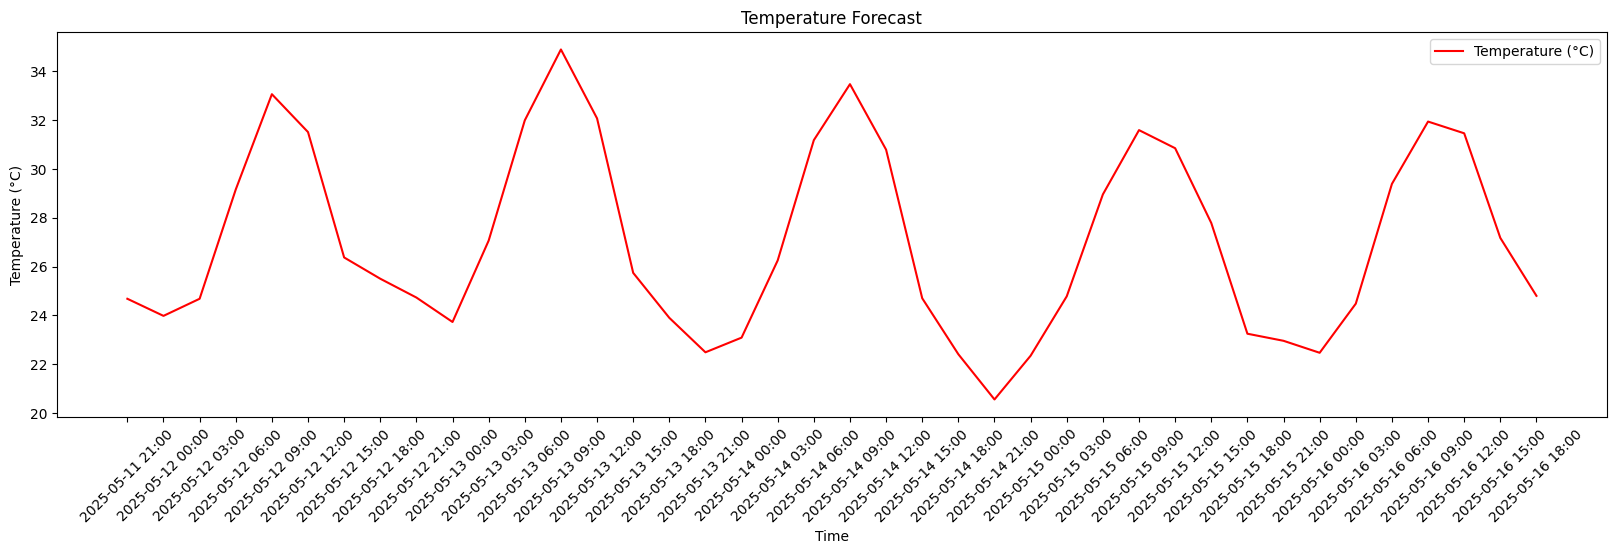

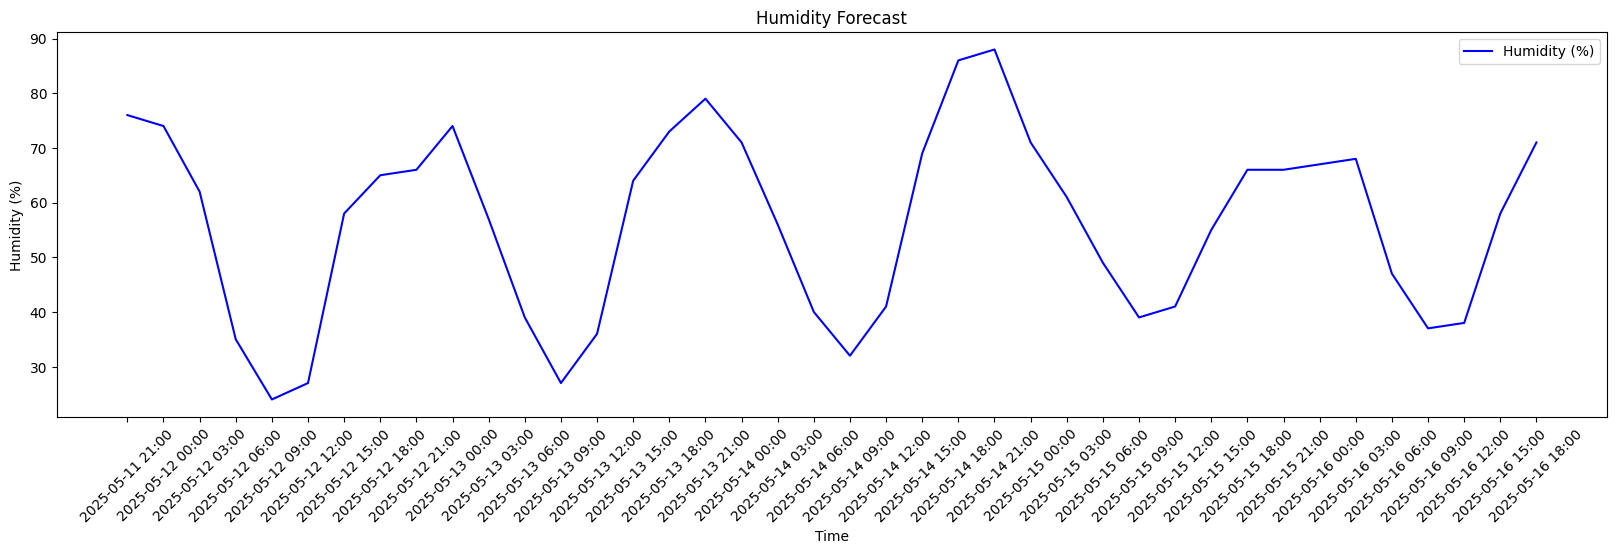

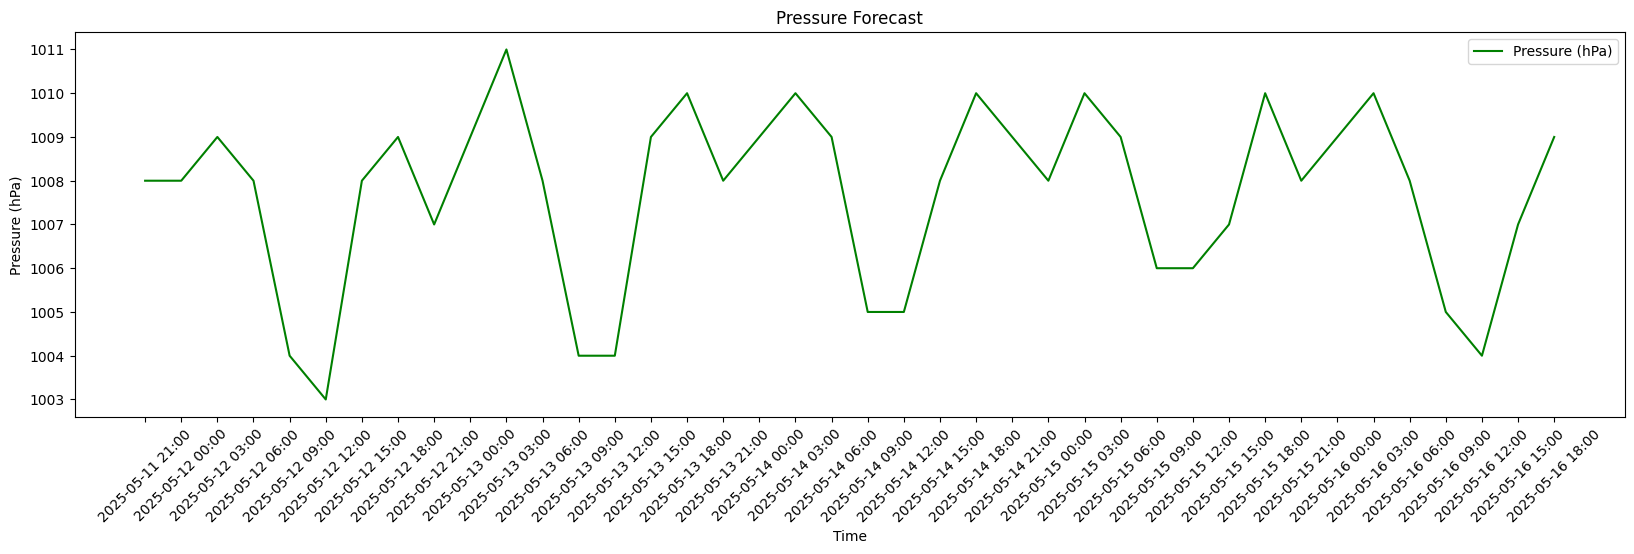

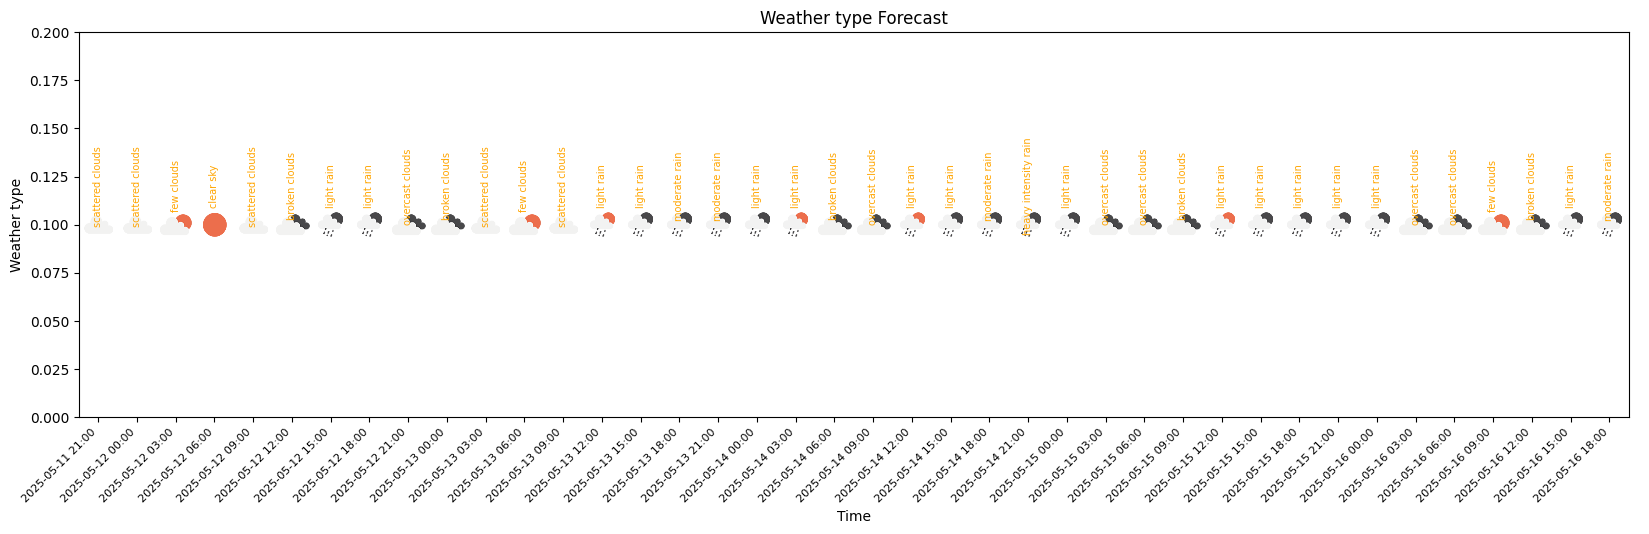

+--------------------------------------------------------------------+
|                       Weather Forecast Table                       |
+------------------+--------+----------------------+------+----------+
|       Time       |  Temp  |         Icon         | Rain |   Wind   |
+------------------+--------+----------------------+------+----------+
| 2025-05-11 21:00 | 24.7°C |   scattered clouds   | 0 mm | 4.19 m/s |
| 2025-05-12 00:00 | 24.0°C |   scattered clouds   | 0 mm | 2.94 m/s |
| 2025-05-12 03:00 | 24.7°C |      few clouds      | 0 mm | 3.32 m/s |
| 2025-05-12 06:00 | 29.2°C |      clear sky       | 0 mm | 1.87 m/s |
| 2025-05-12 09:00 | 33.1°C |   scattered clouds   | 0 mm | 1.1 m/s  |
| 2025-05-12 12:00 | 31.5°C |    broken clouds     | 0 mm | 1.4 m/s  |
| 2025-05-12 15:00 | 26.4°C |      light rain      | 0 mm | 6.72 m/s |
| 2025-05-12 18:00 | 25.5°C |      light rain      | 0 mm | 4.91 m/s |
| 2025-05-12 21:00 | 24.7°C |   overcast clouds    | 0 mm | 4.89 m/s |
| 2025

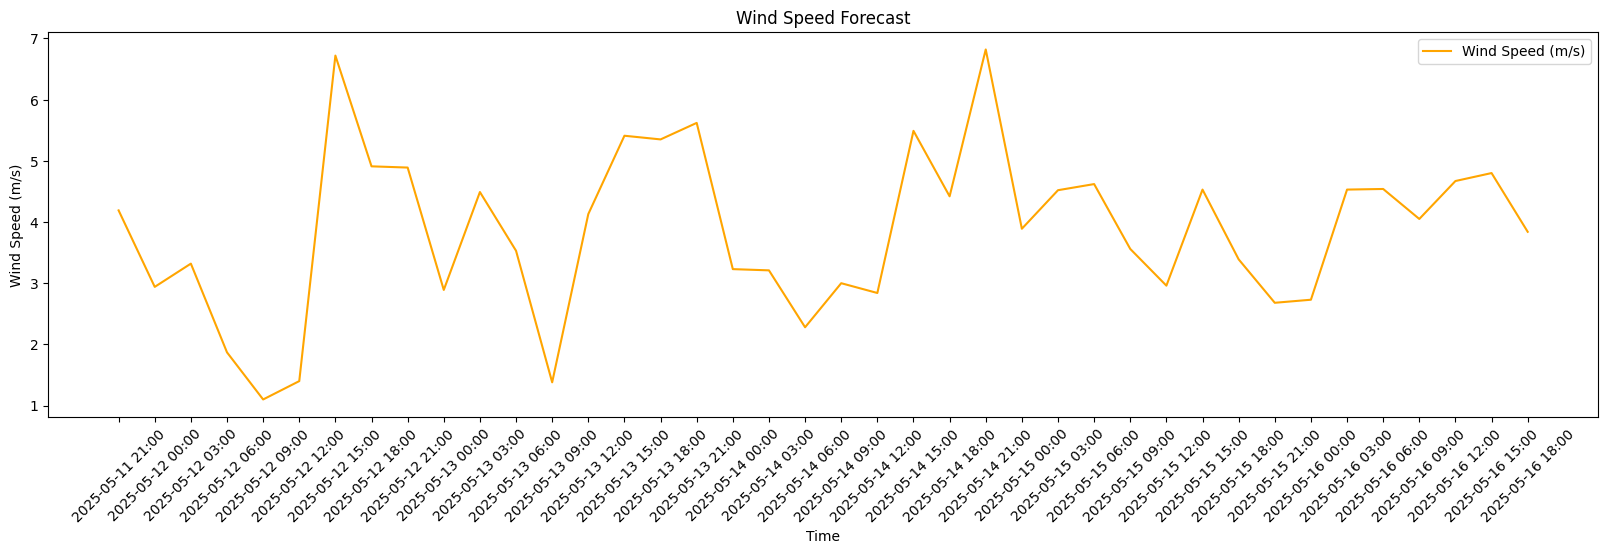

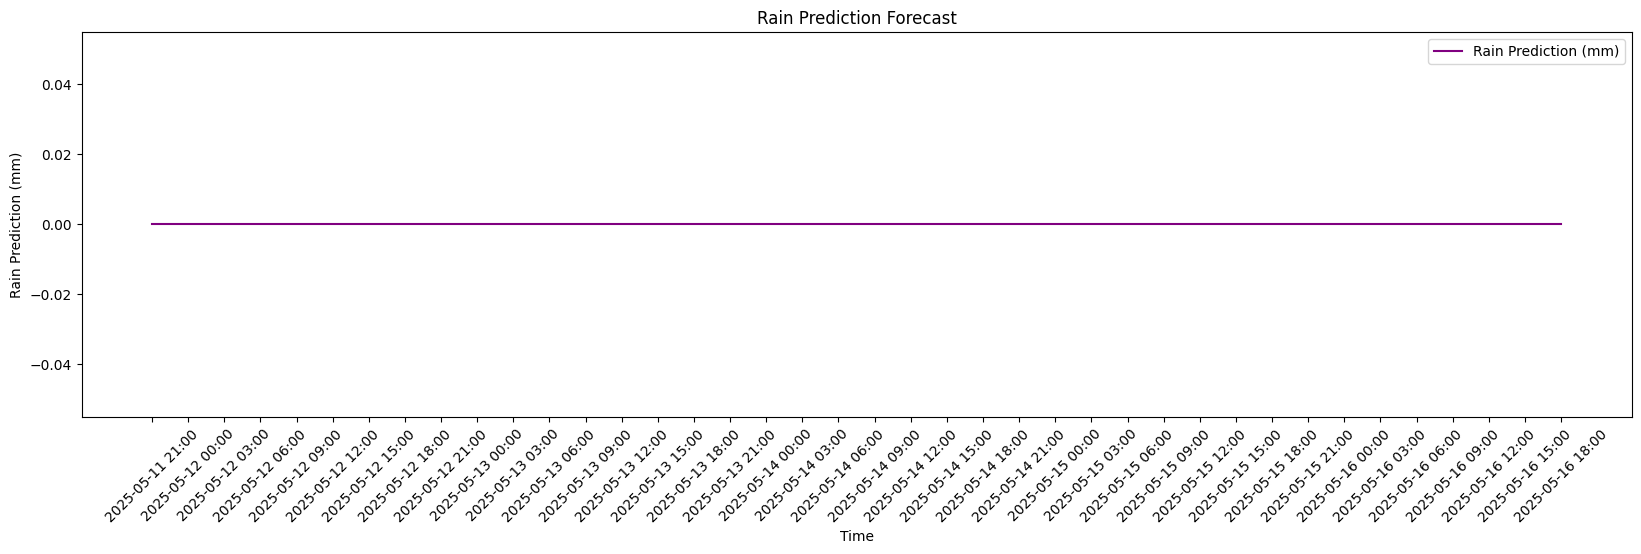

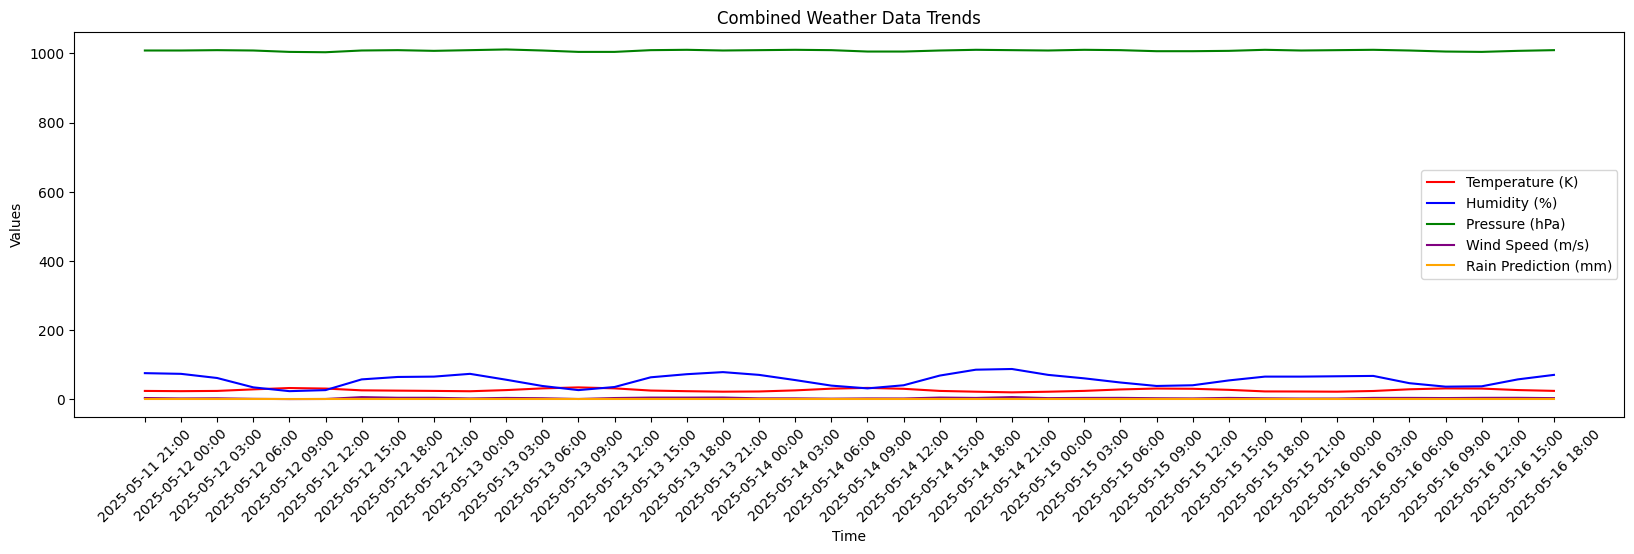

2025-05-11 21:00: Clouds
2025-05-12 00:00: Clouds
2025-05-12 03:00: Clouds
2025-05-12 06:00: Clear
2025-05-12 09:00: Clouds
2025-05-12 12:00: Clouds
2025-05-12 15:00: Rain
2025-05-12 18:00: Rain
2025-05-12 21:00: Clouds
2025-05-13 00:00: Clouds
2025-05-13 03:00: Clouds
2025-05-13 06:00: Clouds
2025-05-13 09:00: Clouds
2025-05-13 12:00: Rain
2025-05-13 15:00: Rain
2025-05-13 18:00: Rain
2025-05-13 21:00: Rain
2025-05-14 00:00: Rain
2025-05-14 03:00: Rain
2025-05-14 06:00: Clouds
2025-05-14 09:00: Clouds
2025-05-14 12:00: Rain
2025-05-14 15:00: Rain
2025-05-14 18:00: Rain
2025-05-14 21:00: Rain
2025-05-15 00:00: Rain
2025-05-15 03:00: Clouds
2025-05-15 06:00: Clouds
2025-05-15 09:00: Clouds
2025-05-15 12:00: Rain
2025-05-15 15:00: Rain
2025-05-15 18:00: Rain
2025-05-15 21:00: Rain
2025-05-16 00:00: Rain
2025-05-16 03:00: Clouds
2025-05-16 06:00: Clouds
2025-05-16 09:00: Clouds
2025-05-16 12:00: Clouds
2025-05-16 15:00: Rain
2025-05-16 18:00: Rain
No weather alerts for this location.


In [16]:
forecast_report = weather_report.get_forecast_report()